# K-means: California housing

In [39]:
# Handle imports up-front
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

from utils import cross_val

## 1. Data loading
### 1.1. Load

In [40]:
raw_data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv")

### 1.2. Inspect

In [41]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### 1.3. Remove unnecessary features

In [42]:
data_df=raw_data_df[['MedInc', 'Latitude', 'Longitude']]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MedInc     20640 non-null  float64
 1   Latitude   20640 non-null  float64
 2   Longitude  20640 non-null  float64
dtypes: float64(3)
memory usage: 483.9 KB


### Test-train split

In [43]:
training_data, testing_data=train_test_split(data_df, test_size=0.2, random_state=42)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MedInc     16512 non-null  float64
 1   Latitude   16512 non-null  float64
 2   Longitude  16512 non-null  float64
dtypes: float64(3)
memory usage: 516.0 KB


## 2. EDA
### 2.1. Missing, and/or extreme values

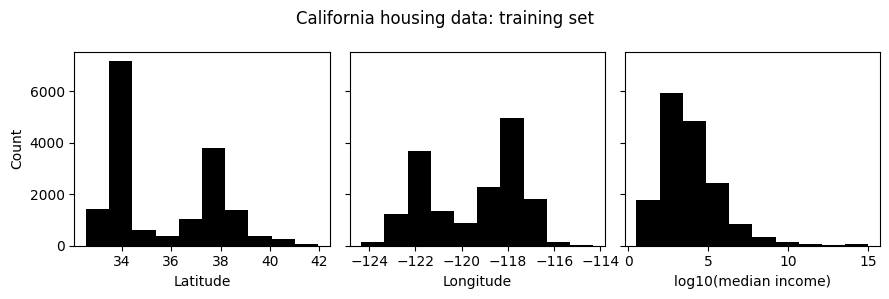

In [44]:
fig, ax=plt.subplots(1, 3, figsize=(9, 3), sharey=True)

fig.suptitle('California housing data: training set')

ax[0].set_ylabel('Count')

ax[0].hist(training_data['Latitude'], color='black')
ax[0].set_xlabel('Latitude')

ax[1].hist(training_data['Longitude'], color='black')
ax[1].set_xlabel('Longitude')

ax[2].hist(training_data['MedInc'], color='black')
ax[2].set_xlabel('log10(median income)')

plt.tight_layout()
plt.show()

### 2.2. Feature scaling

In [45]:
scaler=MinMaxScaler()
scaler.fit(training_data)

scaled_training_data=scaler.transform(training_data)
scaled_training_data=pd.DataFrame(scaled_training_data, columns=training_data.columns)

scaled_testing_data=scaler.transform(testing_data)
scaled_testing_data=pd.DataFrame(scaled_testing_data, columns=testing_data.columns)

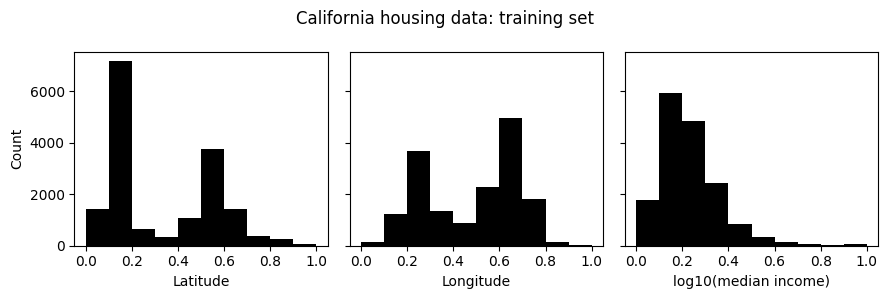

In [46]:
fig, ax=plt.subplots(1, 3, figsize=(9, 3), sharey=True)

fig.suptitle('California housing data: training set')

ax[0].set_ylabel('Count')

ax[0].hist(scaled_training_data['Latitude'], color='black')
ax[0].set_xlabel('Latitude')

ax[1].hist(scaled_training_data['Longitude'], color='black')
ax[1].set_xlabel('Longitude')

ax[2].hist(scaled_training_data['MedInc'], color='black')
ax[2].set_xlabel('log10(median income)')

plt.tight_layout()
plt.show()

## 3. Clustering

### 3.1. Find optimal k value

Text(0, 0.5, 'Within cluster sum of squared distances')

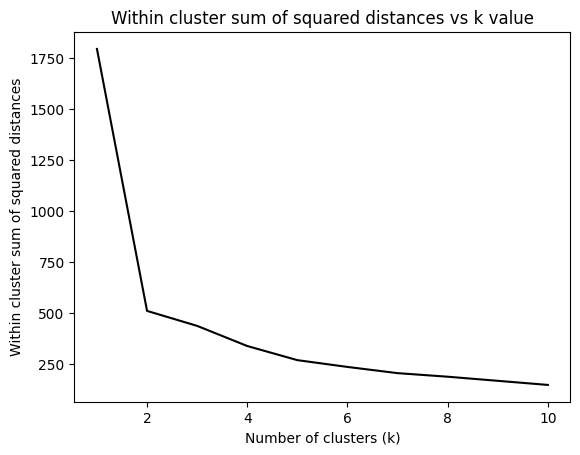

In [47]:
k_values=[1,2,3,4,5,6,7,8,9,10]
ssd=[]

for k in k_values:
    kmeans_model=KMeans(n_clusters=k)
    kmeans_model.fit(scaled_training_data)
    ssd.append(kmeans_model.inertia_)

plt.title('Within cluster sum of squared distances vs k value')
plt.plot(k_values, ssd, color='black')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within cluster sum of squared distances')

### 3.2. Cluster using optimal k value

In [48]:
kmeans_model=KMeans(n_clusters=6)
kemans_fit_result=kmeans_model.fit(scaled_training_data)

### 3.3. Add cluster label to training data

In [49]:
labels=list(kmeans_model.labels_)
scaled_training_data['cluster']=labels
scaled_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MedInc     16512 non-null  float64
 1   Latitude   16512 non-null  float64
 2   Longitude  16512 non-null  float64
 3   cluster    16512 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 451.6 KB


### 3.4. Plot results

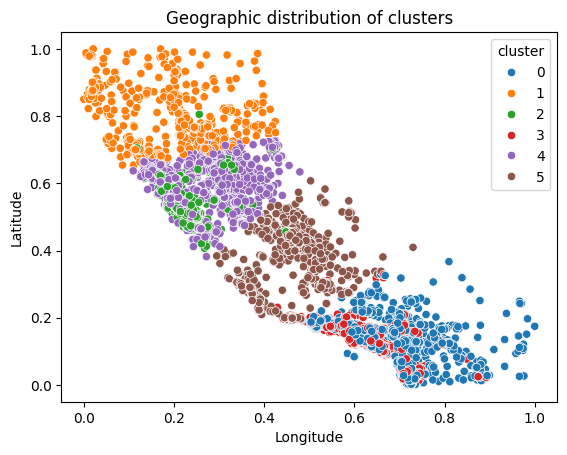

In [50]:
plt.title('Geographic distribution of clusters')
sns.scatterplot(data=scaled_training_data, x='Longitude', y='Latitude', hue='cluster', palette='tab10')
plt.show()

In [51]:
fig=px.scatter_3d(
    scaled_training_data,
    x='Longitude',
    y='Latitude',
    z='MedInc',
    color='cluster',
    width=800,
    height=800,
)

fig.update_traces(marker_size=1)

camera=dict(
    up=dict(x=1, y=3.5, z=0),
    eye=dict(x=2, y=0, z=0)
)

fig.update_layout(scene_camera=camera)
fig.show()

## 4. Supervised classification model
### 4.1. Features & labels

In [52]:
labels=scaled_training_data['cluster'].reset_index(drop=True)
features=scaled_training_data.drop('cluster', axis=1).reset_index(drop=True)
features.head()

MedInc  Latitude  Longitude
0  0.190322  0.017021   0.729084
1  0.228452  0.129787   0.616534
2  0.252162  0.224468   0.385458
3  0.099488  0.014894   0.721116
4  0.210638  0.450000   0.453187

In [53]:
print(list(labels[:10]))

[0, 0, 5, 0, 5, 2, 0, 2, 0, 3]


### 4.2. Model training

In [54]:
classification_model=GradientBoostingClassifier()
fit_result=classification_model.fit(features, labels)

### 4.3. Cross-validation

In [55]:
scores=cross_val(classification_model, features, labels)

Cross-validation accuracy: 99.35 +/- 0.21%


### 4.4. Model evaluation

In [56]:
testing_predictions=classification_model.predict(scaled_testing_data)
testing_labels=list(kmeans_model.predict(scaled_testing_data))
result=accuracy_score(testing_labels, testing_predictions)

print(f'Supervised model is {result*100:.1f}% accurate on the held-out test data.')

Supervised model is 99.6% accurate on the held-out test data.


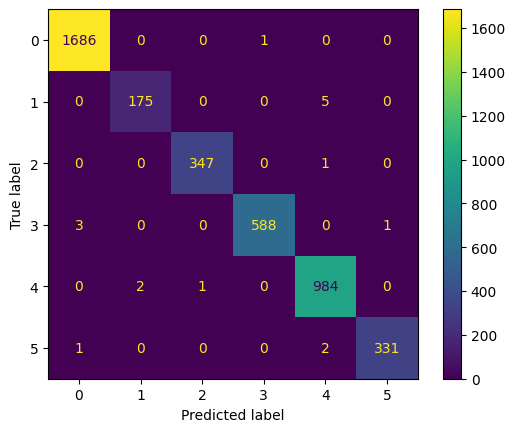

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_estimator(classification_model, scaled_testing_data, testing_labels)